In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import numpy.random as npr
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
plt.style.use('bmh')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

In [3]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']

print(data_train.shape, labels_train.shape)

(270000, 3124) (3124,)


In [9]:
#splitting for training data and validation data
X_train, X_test, y_train, y_test = train_test_split(data_train.transpose(), labels_train, test_size=0.10)
X_train, X_test, y_train, y_test
X_train = np.resize(X_train,(X_train.shape[0],300,300,3)) 
X_test = np.resize(X_test,(X_test.shape[0],300,300,3))
y_train_new = y_train - 1
y_test_new = y_test - 1
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_new))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_new))

2811


In [5]:
#training the CNN Model

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

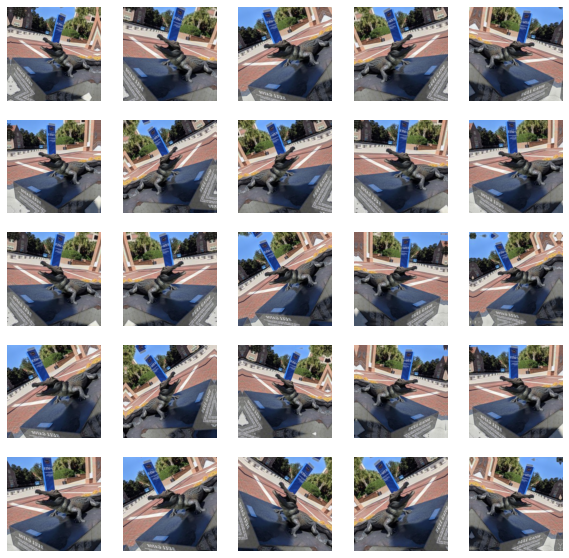

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(25):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
num_classes = 10

model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_filepath = 'final_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

epochs=80
history = model_aug.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs,
  callbacks = [model_checkpoint_callback]
)

Epoch 1/40
40/40 [==============================] - 150s 4s/step - loss: 2.2865 - accuracy: 0.1096 - val_loss: 2.2106 - val_accuracy: 0.1568
Epoch 2/40
40/40 [==============================] - 148s 4s/step - loss: 2.1441 - accuracy: 0.1901 - val_loss: 2.0088 - val_accuracy: 0.2928
Epoch 3/40
40/40 [==============================] - 147s 4s/step - loss: 1.9338 - accuracy: 0.2889 - val_loss: 1.9240 - val_accuracy: 0.3088
Epoch 4/40
40/40 [==============================] - 151s 4s/step - loss: 1.8102 - accuracy: 0.3501 - val_loss: 1.7720 - val_accuracy: 0.3696
Epoch 5/40
40/40 [==============================] - 150s 4s/step - loss: 1.5923 - accuracy: 0.4446 - val_loss: 1.5016 - val_accuracy: 0.4640
Epoch 6/40
40/40 [==============================] - 144s 4s/step - loss: 1.4541 - accuracy: 0.4770 - val_loss: 1.3998 - val_accuracy: 0.5152
Epoch 7/40
40/40 [==============================] - 144s 4s/step - loss: 1.3554 - accuracy: 0.5262 - val_loss: 1.4639 - val_accuracy: 0.4960
Epoch 8/40
40

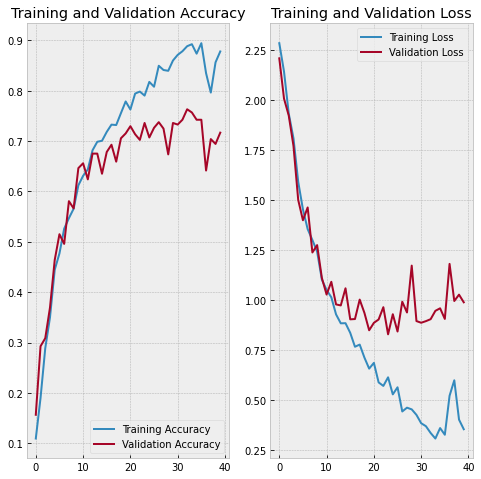

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()